In [28]:
from dataloaders.dataset_class_bert import TextDataset
from torch.utils.data import DataLoader, Subset

dataset = TextDataset('/common/home/ac1771/Desktop/prompt-reconstruction/data', vectorize=1)

In [29]:
from sklearn.model_selection import train_test_split

train_indices, test_indices = train_test_split(
    range(len(dataset)),
    test_size=0.2,
    stratify=dataset.labels,
    random_state=42
)

train_subset = Subset(dataset, train_indices)
test_subset = Subset(dataset, test_indices)

# Create data loaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

In [30]:
import torch
from torch import nn 

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # self.fc0 = nn.Linear(16235, 768)  # Input layer
        self.fc1 = nn.Linear(768, 256)  # First hidden layer
        self.fc2 = nn.Linear(256, 128)  # Second hidden layer
        self.fc3 = nn.Linear(128, 100)  # Output layer
        
        self.relu = nn.ReLU()  # Activation function

    def forward(self, x):
        # x = self.relu(self.fc0(x))
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # Output logits for use with CrossEntropyLoss
        return x

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = NeuralNetwork().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

NeuralNetwork(
  (fc1): Linear(in_features=768, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=100, bias=True)
  (relu): ReLU()
)


In [32]:
num_epochs = 10
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (text, labels, vector) in enumerate(train_loader):
        # Forward pass
        outputs = model(vector.float())
        loss = criterion(outputs, labels.long())
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()


    print(f"Epoch: [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")

Epoch: [1/10], Loss: 3.8288722873963033
Epoch: [2/10], Loss: 3.187871697022743
Epoch: [3/10], Loss: 2.015867109151231
Epoch: [4/10], Loss: 1.1029223596926816
Epoch: [5/10], Loss: 0.6419178865005061
Epoch: [6/10], Loss: 0.40606360122100593
Epoch: [7/10], Loss: 0.27762415613403024
Epoch: [8/10], Loss: 0.20556252768512853
Epoch: [9/10], Loss: 0.15544944379440287
Epoch: [10/10], Loss: 0.1171021246802561


In [33]:
from sklearn.metrics import accuracy_score

actual_labels = []
predicted_labels = []

# Iterate through the test dataset
for data, labels, vector in test_loader:
    # Forward pass
    outputs = model(vector.float())
    
    # Get predicted labels
    _, predicted = torch.max(outputs, 1)
    
    # Convert to numpy arrays
    actual_labels.extend(labels.numpy())
    predicted_labels.extend(predicted.numpy())

accuracy = accuracy_score(actual_labels, predicted_labels)

# Output accuracy
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.97


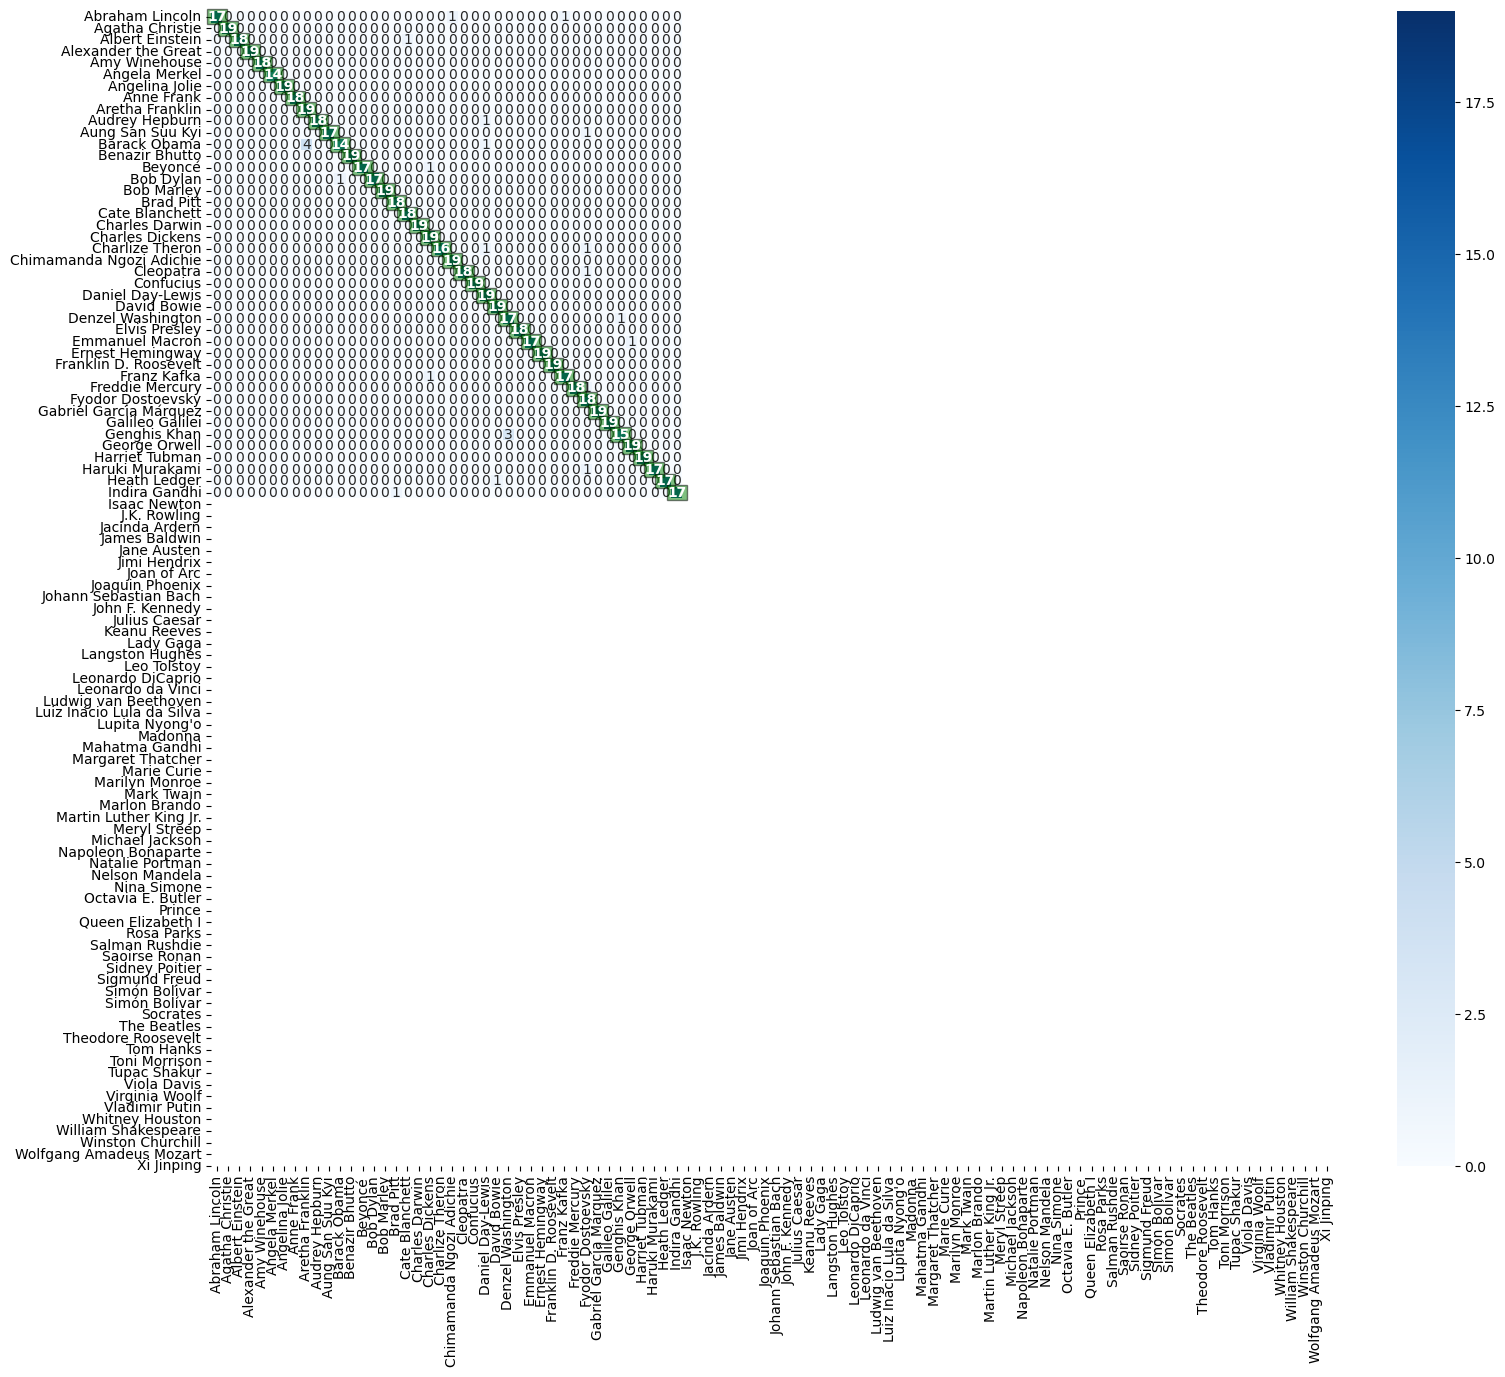

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(actual_labels, predicted_labels)

# Get class labels in alphabetical order
class_labels = dataset.personalities

# Plot confusion matrix with highlighting correct predictions on the diagonal
plt.figure(figsize=(18, 15))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

# Highlight correct predictions on the diagonal
for i in range(min(len(class_labels), conf_matrix.shape[0])):
    plt.text(i + 0.5, i + 0.5, f'{conf_matrix[i, i]}', ha='center', va='center', color='white', fontsize=10, fontweight='bold', bbox=dict(facecolor='green', alpha=0.5, pad=0.3))
